# Принятие решений в бизнесе  

**Описание проекта:**  

Имеются данные крупного интернет-магазина. Аналитик вместе с отделом маркетинга подготовили список гипотез для увеличения выручки.


**Цель проекта:**  

Необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.  
В ходе проведения эксперимента мы будем изучать следующие метрики: кумулятивная выручка, среднее количество заказов на посетителя и размер среднего чека заказа. Именно на основании данных метрик мы будем принимать итоговое решение о результатах А/В тестирования. 

**Описание данных:**  

Гипотезы - **hypothesis.csv**  

`Hypothesis` - краткое описание гипотезы  
`Reach` — охват пользователей по 10-балльной шкале  
`Impact` — влияние на пользователей по 10-балльной шкале  
`Confidence` — уверенность в гипотезе по 10-балльной шкале  
`Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.  

Заказы - **orders.csv**  

`transactionId` — идентификатор заказа  
`visitorId` — идентификатор пользователя, совершившего заказ  
`date` — дата, когда был совершён заказ  
`revenue` — выручка заказа  
`group` — группа A/B-теста, в которую попал заказ.  

Пользователи - **visitors.csv**  

`date` — дата  
`group` — группа A/B-теста  
`visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

In [1]:
# импортируем необходимые библиотеки

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as st
from math import sqrt

pd.set_option('display.max_colwidth', None)

## Загрузка и предобработка данных

In [2]:
try:
    hypothesis,orders,visitors = (pd.read_csv('/datasets/hypothesis.csv'),
                                  pd.read_csv('/datasets/orders.csv'),
                                  pd.read_csv('/datasets/visitors.csv'))
except:
    hypothesis,orders,visitors = (pd.read_csv(r'C:\Users\ANDREY\Documents\datasets\hypothesis.csv', sep = ','),
                                  pd.read_csv(r'C:\Users\ANDREY\Documents\datasets\orders.csv', sep = ','),
                                  pd.read_csv(r'C:\Users\ANDREY\Documents\datasets\visitors.csv', sep = ','))

In [3]:
# функция для вывода необходимых характеристик датафрейма

def data_info(data):
    print(f'\033[1;30m количество строк: \033[0m {data.shape[0]} \n \
          \n\033[1;30m количество столбцов: \033[0m {data.shape[1]}\n')
    print('\033[1;30m информация о датафрейме: \033[0m\n')
    data.info()
    print('\n\033[1;30m первые пять строк датафрейма: \033[0m')
    display(data.head())
    print('\n\033[1;30m количество пропусков в столбцах: \033[0m')
    display(data.isna().sum().sort_values())
    print('\n\033[1;30m количество явных дубликатов: \033[0m', data.duplicated().sum())
    print('\n\033[1;4;30m описание числовых столбцов: \033[0m')
    display(data.describe())

In [4]:
tables = [hypothesis,orders,visitors]
names = ['hypothesis','orders', 'visitors']

for name, table in zip(names, tables):
    print(f'\n\033[7;30m таблица:  {name}\033[0m\n')
    data_info(table)
    print ('*'*41) 


 таблица:  hypothesis

 количество строк:  9 
           
 количество столбцов:  5

 информация о датафрейме: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes

 первые пять строк датафрейма: 


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1



 количество пропусков в столбцах: 


Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64


 количество явных дубликатов:  0

 описание числовых столбцов: 


,Reach,Impact,Confidence,Efforts
count,9.000000,9.000000,9.000000,9.000000
mean,4.777778,4.777778,5.555556,4.888889
std,3.153481,3.192874,3.045944,2.803767
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,7.000000,5.000000
75%,8.000000,7.000000,8.000000,6.000000
max,10.000000,10.000000,9.000000,10.000000


*****************************************

 таблица:  orders

 количество строк:  1197 
           
 количество столбцов:  5

 информация о датафрейме: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB

 первые пять строк датафрейма: 


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B



 количество пропусков в столбцах: 


transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64


 количество явных дубликатов:  0

 описание числовых столбцов: 


,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1.197000e+03
mean,2.155621e+09,2.165960e+09,8.348006e+03
std,1.229085e+09,1.236014e+09,3.919113e+04
min,1.062393e+06,5.114589e+06,5.000000e+01
25%,1.166776e+09,1.111826e+09,1.220000e+03
50%,2.145194e+09,2.217985e+09,2.978000e+03
75%,3.237740e+09,3.177606e+09,8.290000e+03
max,4.293856e+09,4.283872e+09,1.294500e+06


*****************************************

 таблица:  visitors

 количество строк:  62 
           
 количество столбцов:  3

 информация о датафрейме: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB

 первые пять строк датафрейма: 


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756



 количество пропусков в столбцах: 


date        0
group       0
visitors    0
dtype: int64


 количество явных дубликатов:  0

 описание числовых столбцов: 


,visitors
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


*****************************************


Названия столбцов таблицы **hypothesis** приведем к нижнему регистру, таблицы **orders** - к змеиному регистру, где это необходимо. Заменим тип данных столбцов с датой на **datetime**

In [5]:
hypothesis.columns = hypothesis.columns.str.lower()
orders.columns = [x.replace('Id', '_id') for x in orders.columns]
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

Посмотрим на сроки проведения теста для группы А и В

In [6]:
print(f'\nТест для группы А проходил c \033[1;30m{orders[orders["group"]=="A"]["date"].dt.date.min()}\033[0m по \033[1;30m{orders[orders["group"]=="A"]["date"].dt.date.max()}\033[0m\
        \nТест для группы B проходил c \033[1;30m{orders[orders["group"]=="B"]["date"].dt.date.min()}\033[0m по \033[1;30m{orders[orders["group"]=="B"]["date"].dt.date.max()}\033[0m')


Тест для группы А проходил c 2019-08-01 по 2019-08-31        
Тест для группы B проходил c 2019-08-01 по 2019-08-31


In [7]:
print(f'\nТест для группы А проходил c \033[1;30m{visitors[visitors["group"]=="A"]["date"].dt.date.min()}\033[0m по \033[1;30m{visitors[visitors["group"]=="A"]["date"].dt.date.max()}\033[0m\
        \nТест для группы B проходил c \033[1;30m{visitors[visitors["group"]=="B"]["date"].dt.date.min()}\033[0m по \033[1;30m{visitors[visitors["group"]=="B"]["date"].dt.date.max()}\033[0m')


Тест для группы А проходил c 2019-08-01 по 2019-08-31        
Тест для группы B проходил c 2019-08-01 по 2019-08-31


В обеих таблицах сроки проведения теста для двух групп совпадают. Тест длился один месяц.  
Посмотрим как распределялись пользователи по группам

In [8]:
visitors['group'].value_counts()

A    31
B    31
Name: group, dtype: int64

In [9]:
visitors.groupby('group')['visitors'].sum()

group
A    18736
B    18916
Name: visitors, dtype: int64

Доли пользователей в таблице visitors равны, относительное различие количества пользователей в группе А и В составляет менее 1%.  
Посмотрим на распределение пользователей в таблице orders.

In [10]:
_ = orders.groupby('group')['visitor_id'].nunique().reset_index()
_

,group,visitor_id
0,A,503
1,B,586


In [11]:
print(f'Относительное различие количества пользователей в таблице orders - {round((1-(_["visitor_id"][0]/_["visitor_id"].sum())/(_["visitor_id"][1]/_["visitor_id"].sum()))*100)} %')

Относительное различие количества пользователей в таблице orders - 14 %


В данном случае мы видим дисбаланс среди участников теста. На практике, при проведении А/В теста такого быть не должно, на этапе подготовки используют специальные калькуляторы, которые высчитывают необходимое количество участников в каждой группе, а также проводят АА тест, чтобы проверить корректность работы механизма A/B-тестирования.

Проверим, не попали ли случайно пользователи и в группу А и в группу В.

In [12]:
double_groups = orders.groupby('visitor_id')['group'].nunique().reset_index()
double_groups[double_groups['group']>1]['visitor_id'].count()

58

У нас 58 уникальных пользователей, которые случайно оказались и в группе А и в группе В. Посмотрим на этих пользователей и на количество покупок, которое они совершили.

In [13]:
# для примера возьмем два случайных пользователя

orders.query('visitor_id == 8300375 or visitor_id == 232979603')

,transaction_id,visitor_id,date,revenue,group
71,3679129301,8300375,2019-08-01,10510,B
703,4293855558,8300375,2019-08-07,1790,A
1009,2670069237,232979603,2019-08-31,2640,B
1013,83566152,232979603,2019-08-31,60,A


Действительно пользователи попали в обе группы, чего при проведении А/В тестов быть не должно.

In [14]:
# сохраним id пользователей, оказавшихся в двух группах

list_double = double_groups[double_groups['group']>1]['visitor_id']

In [15]:
orders.query('visitor_id in @list_double')['transaction_id'].count()

181

58 пользователей, оказавшихся в обеих группах, совершили 181 покупку. По правилам проведения А/В тестов попадание уникального пользователя в разные группы плохая история, которая может сильно отразиться на результате, ведь доля пользователей будет видеть оба варианта эксперимента.  Удалим данных пользователей, т.к. в последующем мы не можем с уверенностью оценить, что изменение произошло именно из-за новой идеи, а не потому что это типичное поведение пользователя.

In [16]:
orders = orders.query('visitor_id not in @list_double').reset_index(drop=True)

На данном этапе мы выгрузили и предобработали полученные данные, где это было необходимо.  
- всего у нас 3 датафрейма: с информацией о выдвигаемых гипотезах, данными о заказах и посетителях.
- пропуски и дубликаты во всех таблицах отсутствуют, заменили тип данных столбцов с датой на datetime, изменили названия столбцов согласно принятому стандарту. 
- длительность теста составила 1 месяц - с 1 по 31 августа 2019 года.
- в таблице orders выявили дисбаланс среди количества пользователей по группам, также 58 уникальных пользователей при проведении А/В теста попали в обе группы, чего не должно быть при проведении теста, удалили данных пользователей. Данную информацию необходимо донести до составителей теста, чтобы были доработаны этапы проведения А/В теста в будущем.
- В таблице orders минимальная и максимальная стоимости заказа существенно различаются: минимальная стоимость заказа составила 50 рублей, максимальная же ~ 1.300 млн. рублей, при этом средняя стоимость заказа составила ~ 8500 рублей, а 75% пользователей платили за заказ не более 8290 рублей. 

## Приоритизация гипотез.

В нашем распоряжении 9 гипотез. Чтобы максимизировать ожидаемое улучшение ключевых метрик бизнеса, сформулированные гипотезы приоритизируют. Для этого воспользуемся одним из самых популярных способов приоритизации - **ICE** и его модификацией **RICE**, отсортируем их по убыванию приоритета, посмотрим изменилась ли приоритизация гипотез при применении RICE вместо ICE.  
Для начала выведем все гипотезы и посмотрим как распределились оценки.

In [17]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


**Фреймворк ICE**  

`ICE SCORE = (Impact * Confidence) / Efforts`  

**Impact** показывает, насколько сильно изменение повлияет на охваченных пользователей  
**Confidence** показывает, насколько мы уверены в оценках других параметров  
**Efforts** показывает, насколько сложно проверить гипотезу

In [18]:
hypothesis['ice'] = round((hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']), 2)
hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending=False)

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Гипотеза с индексом 8 - Запуск акции, дающую скидку на товар в день рождения - высокая оценка влияния на пользователей (9) усиливается высокой уверенностью в оценке всех параметров (9) и при относительно небольших усилиях (5) выводит данную гипотезу в лидеры. Далее в приоритете следуют гипотезы с индексом 0 (Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей) и с индексом 7 (Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок).  

Далее рассмотрим приоритизацию гипотез согласно фреймворку RICE.  

**Фреймворк RICE**  

`RICE SCORE = (Reach * Impact * Confidence) / Efforts`  

**Reach** показывает, скольких пользователей затронет внесенное изменение

In [19]:
hypothesis['rice'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis[['hypothesis', 'rice']].sort_values(by='rice', ascending=False)

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Гипотезы с индексом 7 и 0 остались в тройке лидеров, при этом гипотеза о "добавлении формы подписки на все основные страницы" (индекс 7) вырвалась на первое место за счет наивысшей оценки reach. Гипотеза с нулевым индексом, наоборот, опустилась со второго на третье место, здесь также роль сыграла оценка количества охваченных пользователей в 3 балла, но максимальная оценка (10 баллов) влияние изменения на пользователей позволила данной гипотезе остаться в тройке лидеров. На второе место перешла гипотеза с индексом 2 (добавление блоков рекомендаций товаров на сайт интернет магазина), у нее высокая оценка reach (8 баллов) и низкая оценка сложности реализации данной гипотезы (efforts = 3 балла).  

Визулизируем полученные результаты.

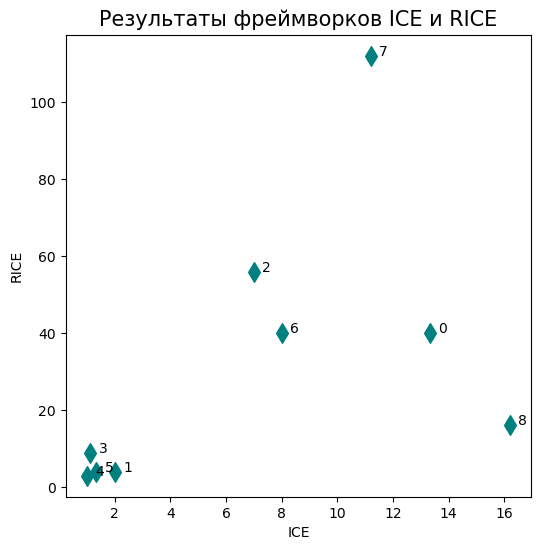

In [20]:
plt.figure(figsize=(6,6))
x = hypothesis['ice'] 
y = hypothesis['rice'] 
labs = hypothesis.index 

plt.scatter(x, y, marker='d', color='teal', s=100)

for i, txt in enumerate(labs):
    plt.annotate(txt, (x[i]+.3, y[i]))
plt.title('Результаты фреймворков ICE и RICE', fontsize=15)
plt.ylabel('RICE')
plt.xlabel('ICE')
plt.show()

Как мы видим приоритет гипотез различается среди фреймворков. Две гипотезы с индексами 7 и 0 попали в тройку лидеров в обоих случаях. Гипотеза с индексом 8, лидирующая во фреймворке ICE опустилась с первого места на пятое, в то время как гипотеза с индексом 2, наоборот, во фреймфорке RICE поднялась с пятого на второе место. В данном случае помимо оценки гипотезы, важно учитывайть и то как много пользователей охватывает гипотеза, так гипотеза 8 имеет параметр reach 1/10, в то время как гипотеза 2 - 8/10.

## Анализ A/B-теста

Был проведен A/B-тест и получены результаты, которые описаны в наших датафреймах `orders` и `visitors`. Напомним, что в таблице orders были удалены пользователи, которые попали в обе группы теста, а так как в таблице visitors у нас агрегированная информация без данных о конкретных пользователях, возможности корректно обработать дубликаты у нас нет. В данном случае допускаем наличие дубликатов.

### Построим график кумулятивной выручки по группам.   

Для начала, чтобы построить графики, необходимо собрать кумулятивные данные.

In [21]:
# создаем массив уникальных пар значений дат и групп теста

date_groups = orders[['date','group']].drop_duplicates() 
date_groups.head()

,date,group
0,2019-08-15,B
6,2019-08-15,A
35,2019-08-16,A
37,2019-08-16,B
45,2019-08-01,A


In [22]:
# получаем агрегированные кумулятивные данные по дням о заказах 

agg_orders = (date_groups
                    .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
                           .agg({'date' : 'max', 
                                 'group' : 'max', 
                                 'transaction_id' : 'nunique', 
                                 'visitor_id' : 'nunique', 
                                 'revenue' : 'sum'}), axis=1)
                    .sort_values(by=['date','group'])
                   )
agg_orders.head()

,date,group,transaction_id,visitor_id,revenue
45,2019-08-01,A,23,19,142779
54,2019-08-01,B,17,17,59758
149,2019-08-02,A,42,36,234381
147,2019-08-02,B,40,39,221801
245,2019-08-03,A,66,60,346854


In [23]:
# получаем агрегированные кумулятивные данные по дням о посетителях 
agg_visitors = (date_groups
                      .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
                             .agg({'date' : 'max', 
                                   'group' : 'max', 
                                   'visitors' : 'sum'}), axis=1)
                      .sort_values(by=['date','group'])
                     )
agg_visitors.head()

,date,group,visitors
45,2019-08-01,A,719
54,2019-08-01,B,713
149,2019-08-02,A,1338
147,2019-08-02,B,1294
245,2019-08-03,A,1845


In [24]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cum_data = agg_orders.merge(agg_visitors, left_on=['date', 'group'], right_on=['date', 'group'])
cum_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# добавим столбец со средним чеком заказа
cum_data['avg_check'] = cum_data['revenue'] / cum_data['orders']

# добавим столбец с отношением заказов к количеству посетителей

cum_data['conversion'] = cum_data['orders']/cum_data['visitors']

cum_data.head(5)

,date,group,orders,buyers,revenue,visitors,avg_check,conversion
0,2019-08-01,A,23,19,142779,719,6207.782609,0.031989
1,2019-08-01,B,17,17,59758,713,3515.176471,0.023843
2,2019-08-02,A,42,36,234381,1338,5580.500000,0.031390
3,2019-08-02,B,40,39,221801,1294,5545.025000,0.030912
4,2019-08-03,A,66,60,346854,1845,5255.363636,0.035772


Проверим корректно ли объединили датафрейм, совпадают максимальная и минимальная даты проведения теста с исходными данными.

In [25]:
print(f'\nТест для группы А проходил c \033[1;30m{cum_data[cum_data["group"]=="A"]["date"].dt.date.min()}\033[0m по \033[1;30m{cum_data[cum_data["group"]=="A"]["date"].dt.date.max()}\033[0m\
        \nТест для группы B проходил c \033[1;30m{cum_data[cum_data["group"]=="B"]["date"].dt.date.min()}\033[0m по \033[1;30m{cum_data[cum_data["group"]=="B"]["date"].dt.date.max()}\033[0m')


Тест для группы А проходил c 2019-08-01 по 2019-08-31        
Тест для группы B проходил c 2019-08-01 по 2019-08-31


In [26]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cum_rev_a = cum_data[cum_data['group']=='A'][['date','revenue', 'orders', 'avg_check', 'conversion']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cum_rev_b = cum_data[cum_data['group']=='B'][['date','revenue', 'orders', 'avg_check', 'conversion']]

**Построим графики кумулятивной выручки по дням и группам A/B-тестирования:**

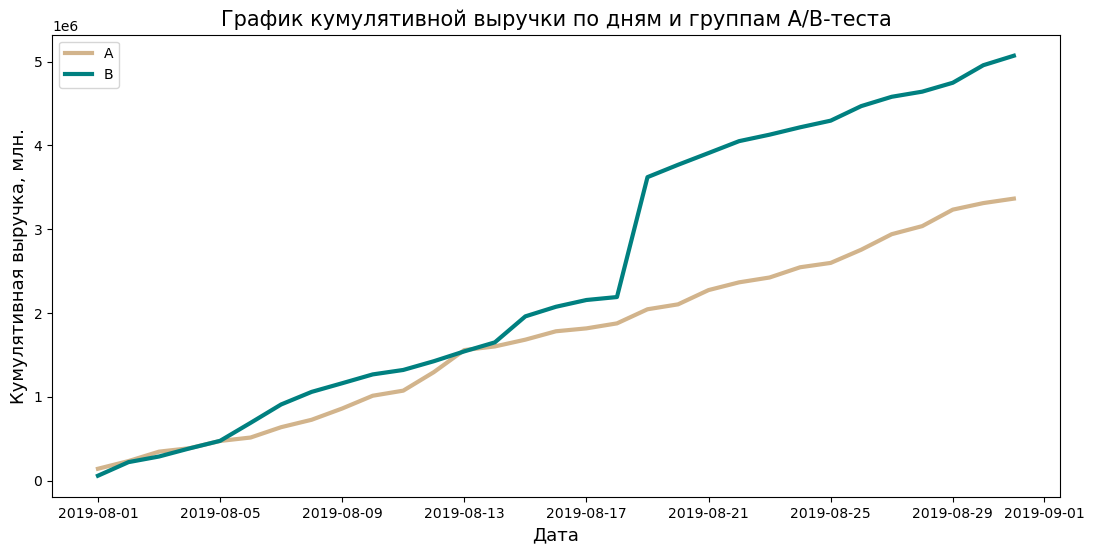

In [27]:
plt.figure(figsize=(13,6))
sns.lineplot(data=cum_rev_a, 
             x=cum_rev_a['date'], 
             y=cum_rev_a['revenue'], 
             color = 'tan', 
             linewidth = 3, 
             label='A')
sns.lineplot(data=cum_rev_b, 
             x=cum_rev_b['date'], 
             y=cum_rev_b['revenue'], 
             color = 'teal', 
             linewidth = 3, 
             label='B')
plt.title('График кумулятивной выручки по дням и группам A/B-теста',fontsize = 15)
plt.xlabel('Дата', fontsize = 13)
plt.ylabel('Кумулятивная выручка, млн.', fontsize = 13)
plt.legend()
plt.show()

Согласно графику, кумулятивная выручка на всем протяжении теста растет по двум группам. У группы А это плавный рост, у группы В мы наблюдаем резкое увеличение кумулятивной выручки приблизительно 18-19 августа и далее плавное увеличение. Вероятно в этот период было совершено бОльшее количество покупок или же очень дорогие приобретения (аномалии). Приблизительно с 15 августа кумулятивная выручка группы В стабильно выше чем у группы А.  

Посмотрим на количество заказов и объем выручки по дням.

In [28]:
orders.groupby('date').agg({'transaction_id':'count', 'revenue':'sum'})

,transaction_id,revenue
date,,
2019-08-01,40,202537
2019-08-02,42,253645
2019-08-03,38,179522
2019-08-04,25,138066
2019-08-05,43,176291
2019-08-06,38,255761
2019-08-07,39,342412
2019-08-08,36,238780
2019-08-09,30,237403


И действительно, 19 августа была максимальная выручка за весь месяц, почти 1.6 млн. рублей, количество заказов в этот день составило 42 при среднем количестве заказов в день ~ 33. 

### Построим график кумулятивного среднего чека по группам.

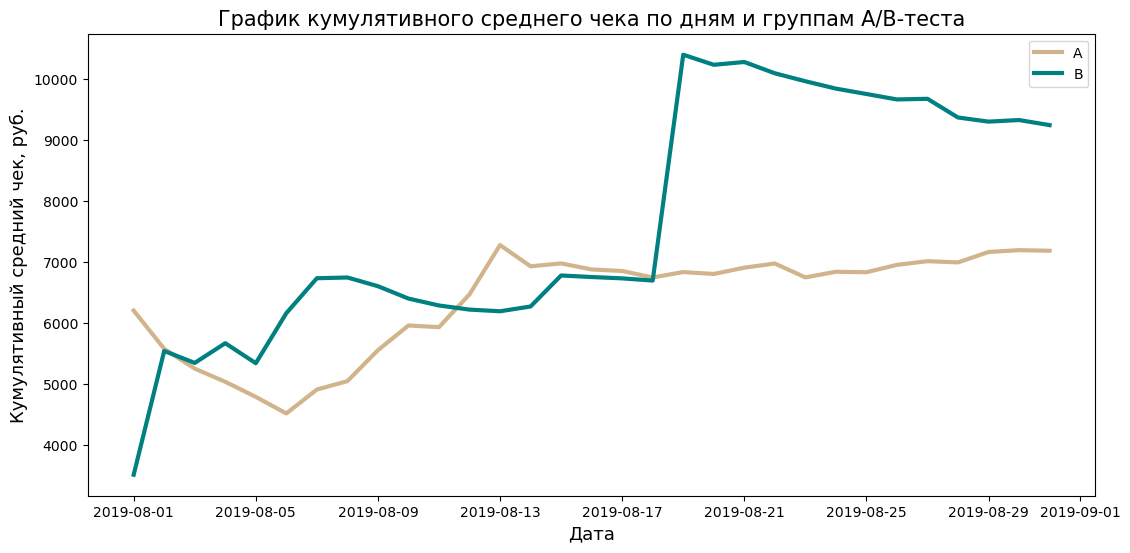

In [29]:
plt.figure(figsize=(13,6))
sns.lineplot(data=cum_rev_a, 
             x=cum_rev_a['date'], 
             y=cum_rev_a['avg_check'], 
             color = 'tan', 
             linewidth = 3, 
             label='A')
sns.lineplot(data=cum_rev_b, 
             x=cum_rev_b['date'], 
             y=cum_rev_b['avg_check'], 
             color = 'teal', 
             linewidth = 3, 
             label='B')
plt.title('График кумулятивного среднего чека по дням и группам A/B-теста',fontsize = 15)
plt.xlabel('Дата', fontsize = 13)
plt.ylabel('Кумулятивный средний чек, руб.', fontsize = 13)
plt.legend()
plt.show()

Графики кумулятивного среднего чека точно нестабильны. В начале проведения теста мы видим сильные перепады как в большую так и в меньшую сторону по обеим группам. Снова наблюдаем резкий рост в группе В 19 августа. Ближе к концу теста колебания графиков снизились, линии более плавные, группа А показывает совсем незначительную тенденцию к росту, у группы В, начиная с 19 августа, график снижается. 

### Построим график относительного изменения кумулятивного среднего чека группы B к группе A. 

In [30]:
# найдем относительное различие среднего чека 

avg_check_ratio = cum_data.pivot_table(index='date', values='avg_check', columns='group', aggfunc='first').reset_index()
avg_check_ratio['ratio'] = avg_check_ratio['B'] / avg_check_ratio['A'] - 1
avg_check_ratio.head()

group,date,A,B,ratio
0,2019-08-01,6207.782609,3515.176471,-0.433747
1,2019-08-02,5580.500000,5545.025000,-0.006357
2,2019-08-03,5255.363636,5349.074074,0.017831
3,2019-08-04,5039.350649,5672.647059,0.125670
4,2019-08-05,4792.050505,5344.359551,0.115255


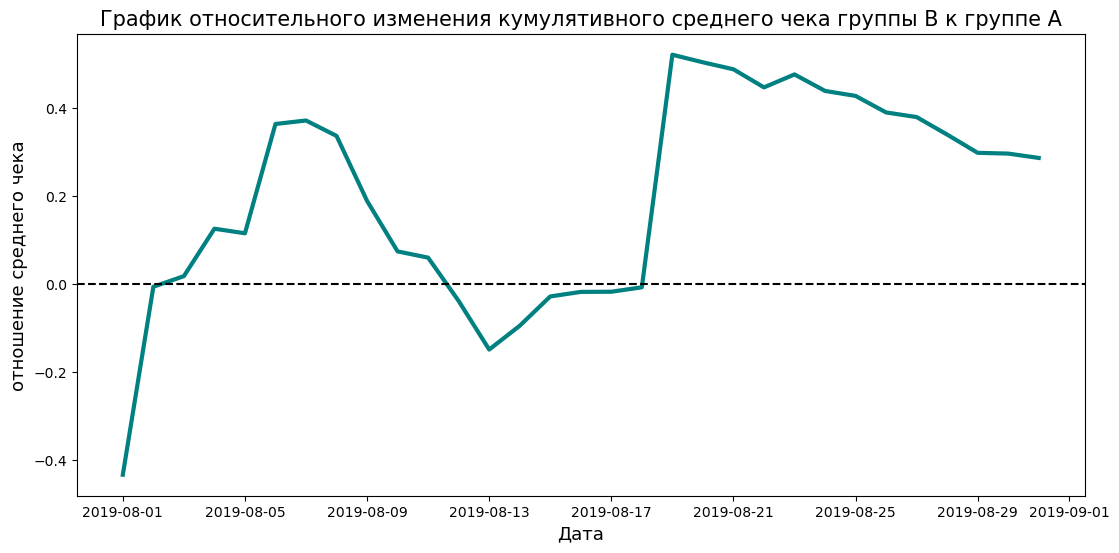

In [31]:
plt.figure(figsize=(13,6))
sns.lineplot(data=avg_check_ratio, 
             x=avg_check_ratio['date'], 
             y=avg_check_ratio['ratio'], 
             color = 'teal', 
             linewidth = 3)
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A',fontsize = 15)
plt.xlabel('Дата', fontsize = 13)
plt.ylabel('отношение среднего чека', fontsize = 13)
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

Здесь мы можем наблюдать, что отношение среднего чека по группам менялось на протяжении теста, средний чек группы В то превосходил показатель группы А, то опускался ниже. Но стоит отметить, что отношение среднего чека группы В превосходит группу А - значительное отклонение выше горизонтальной линии. Резкие изменения направленности кривой вероятно говорят о наличии аномальных/выбивающихся значениях не только 19 августа, но и ранее.   

### Построим график кумулятивного среднего количества заказов на посетителя по группам.

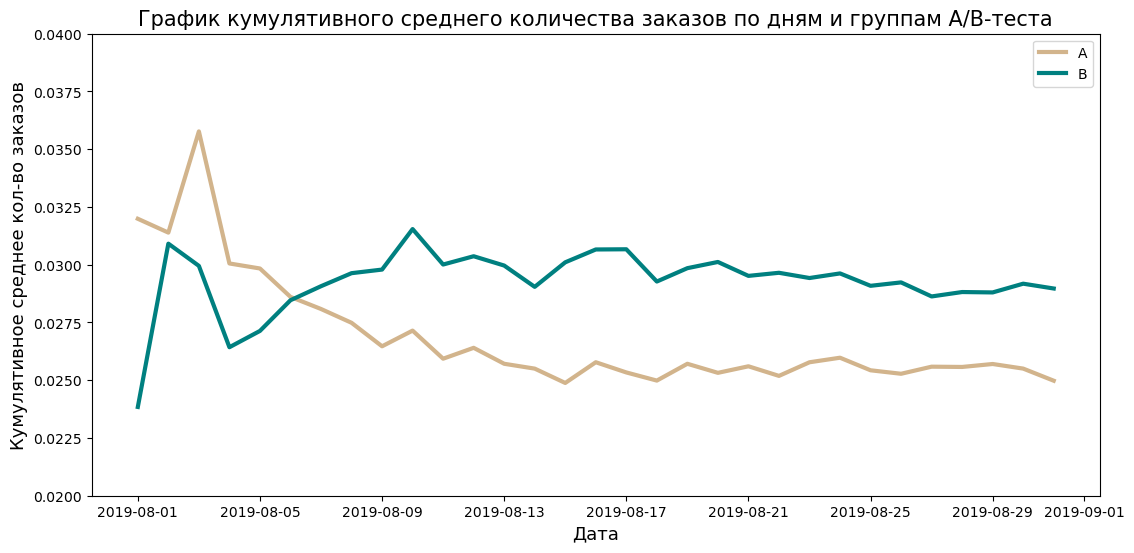

In [32]:
plt.figure(figsize=(13,6))
sns.lineplot(data=cum_rev_a, 
             x=cum_rev_a['date'], 
             y=cum_rev_a['conversion'], 
             color = 'tan', 
             linewidth = 3, 
             label='A')
sns.lineplot(data=cum_rev_b, 
             x=cum_rev_b['date'], 
             y=cum_rev_b['conversion'], 
             color = 'teal', 
             linewidth = 3, 
             label='B')
plt.title('График кумулятивного среднего количества заказов по дням и группам A/B-теста',fontsize = 15)
plt.xlabel('Дата', fontsize = 13)
plt.ylabel('Кумулятивное среднее кол-во заказов', fontsize = 13)
plt.legend()
plt.ylim(0.02, 0.04)
plt.show()

В начале теста кумулятивное среднее количество заказов группы А превышала этот показатель группы В, но приблизительно на 7-й день теста графики перестроились - кривая показателя среднего количества заказов у группы В превышает линию группы А до конца теста. Приблизительно с 25-го августа график группы А стабилизировался, у группы В это пришлось приблизительно на 27й день теста.

### Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

In [33]:
# найдем относительное различие среднего количества заказов 

conv_b_a = cum_data.pivot_table(index='date', values='conversion', columns='group', aggfunc='first').reset_index()
conv_b_a['ratio'] = conv_b_a['B'] / conv_b_a['A'] - 1
conv_b_a.head()

group,date,A,B,ratio
0,2019-08-01,0.031989,0.023843,-0.254650
1,2019-08-02,0.031390,0.030912,-0.015235
2,2019-08-03,0.035772,0.029950,-0.162759
3,2019-08-04,0.030055,0.026428,-0.120659
4,2019-08-05,0.029837,0.027134,-0.090595


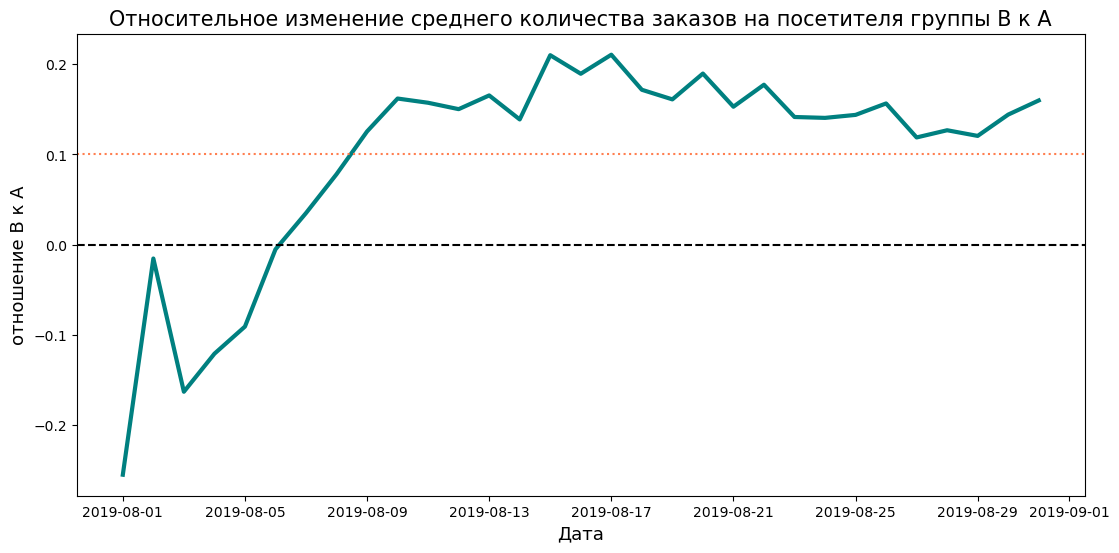

In [34]:
plt.figure(figsize=(13,6))
sns.lineplot(data=conv_b_a, 
             x=conv_b_a['date'], 
             y=conv_b_a['ratio'], 
             color = 'teal', 
             linewidth = 3)
plt.title('Относительное изменение среднего количества заказов на посетителя группы B к A',fontsize = 15)
plt.xlabel('Дата', fontsize = 13)
plt.ylabel('отношение В к А', fontsize = 13)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='coral', linestyle=':')
plt.show()

Примерно с 6-го августа среднее количество заказов на посетителя группы В опередила данный показатель группы А и далее ниже нулевой отметки не опускалась. Видим, что кривая не совсем стабильна, но приблизительно с 9-го августа показатель группым В не опускалась ниже 10%. Если брать во внимание предыдущий график, то мы видим что количество заказов на посетителя группы В действительно выше чем у группы А.

### Построим точечный график количества заказов по пользователям.  

Подсчитаем количество заказов по пользователям.

In [35]:
orders_by_users = orders.groupby('visitor_id', as_index=False).agg({'transaction_id':'nunique'})
orders_by_users.columns = ['user_id', 'orders']
orders_by_users.sort_values(by='orders', ascending=False).head(10)

,user_id,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


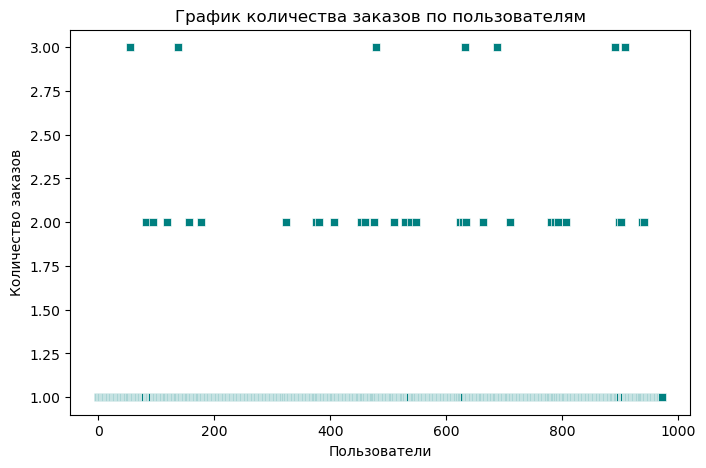

In [36]:
plt.figure(figsize=(8, 5)) 
x_values = pd.Series(range(0, len(orders_by_users)))
sns.scatterplot(data=orders_by_users, 
                x=x_values, 
                y=orders_by_users['orders'], 
                marker='s', 
                color='teal', 
                )
plt.title('График количества заказов по пользователям')
plt.xlabel('Пользователи')
plt.ylabel('Количество заказов')
plt.show()

Как мы видим, основная масса пользователей совершила одну покупку, много меньше - 2 покупки и совсем еденицы - 3 покупки. Странно что мы не видим и большего количества покупок у пользователей, ведь они могли совершать и 4 и 6 и даже 10 покупок за месяц. Вероятнее всего мы исключили данных пользователей на этапе предобработки, т.к. они попали в обе группы теста. 

### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя.  

Выберем границу для определения аномальных пользователей.

In [37]:
perc_95 = np.percentile(orders_by_users['orders'], 95)
perc_99 = np.percentile(orders_by_users['orders'], 99)
print(f'\033[1;30m Не более 5% покупателей оформили больше {perc_95} заказа\033[0m')
print(f'\033[1;30m Не более 1% покупателей оформили больше {perc_99} заказов\033[0m')

 Не более 5% покупателей оформили больше 1.0 заказа
 Не более 1% покупателей оформили больше 2.0 заказов


В данном случае примем за аномальных пользователей тех, кто совершил более 2х заказов

### Построим точечный график стоимостей заказов.

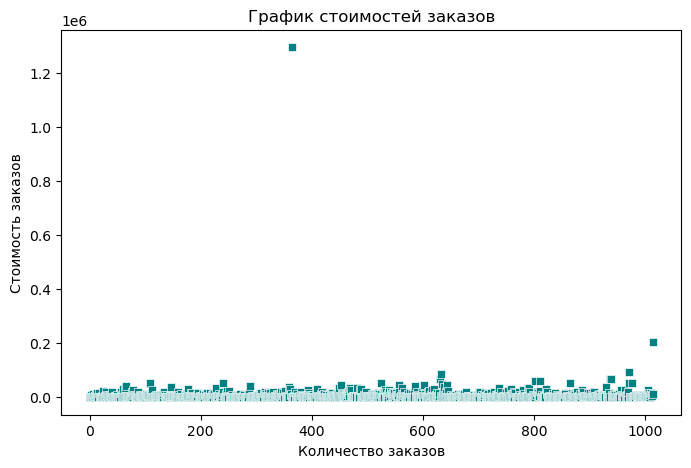

In [38]:
plt.figure(figsize=(8, 5)) 
x_values = pd.Series(range(0, len(orders)))
sns.scatterplot(data=orders, 
                x=x_values, 
                y=orders['revenue'], 
                marker='s', 
                color='teal', 
                )
plt.title('График стоимостей заказов')
plt.xlabel('Количество заказов')
plt.ylabel('Стоимость заказов')
plt.show()

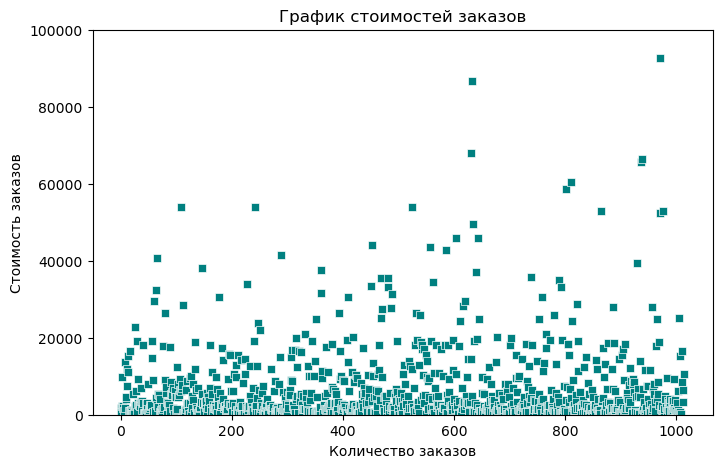

In [39]:
plt.figure(figsize=(8, 5)) 
x_values = pd.Series(range(0, len(orders)))
sns.scatterplot(data=orders, 
                x=x_values, 
                y=orders['revenue'], 
                marker='s', 
                color='teal', 
                )
plt.title('График стоимостей заказов')
plt.xlabel('Количество заказов')
plt.ylabel('Стоимость заказов')
plt.ylim(0, 100000)
plt.show()

На данных графиках мы видим, что чаще всего стоимость заказа была до 10 тысяч рублей и чем выше стоимость, тем таких заказов меньше. На первом графике видим аномальные значения в районе 200тысяч и более 1млн200 тысяч. 

### Посчитаем 95-й и 99-й перцентили стоимости заказов.  

Выберем границу для определения аномальных заказов.

In [40]:
perc_95 = np.percentile(orders['revenue'], 95)
perc_99 = np.percentile(orders['revenue'], 99)
print(f'\033[1;30m Не более 5% покупателей оформили заказ на сумму более {perc_95} рублей\033[0m')
print(f'\033[1;30m Не более 1% покупателей оформили заказ на сумму более {perc_99} рублей\033[0m')

 Не более 5% покупателей оформили заказ на сумму более 26785.0 рублей
 Не более 1% покупателей оформили заказ на сумму более 53904.0 рублей


В данном случае примем за верхнюю границу значение 95 перцентиля и все заказы, стоимость которых более 27 тысяч рублей будем считать аномальными.

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. 

Посчитаем статистическую значимость различий в среднем числе заказов на пользователя между группами по «сырым» данным — без удаления аномальных пользователей.  
Сформулируем гипотезы:
- Н0 - различий в среднем количестве заказов между группами нет.  
- Н1 - различия в среднем между группами есть.  

Создадим переменные `visitors_a` и `visitors_b` с данными о пользователях по группам (дата и количество пользователей), а также переменные `orders_a` и `orders_b` со столбцами `visitors_id` и `orders`. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.   

In [41]:
visitors_a = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_b = visitors[visitors['group'] == 'B'][['date', 'visitors']]

In [42]:
orders_a = orders[orders['group'] == 'A'].groupby('visitor_id', as_index=False).agg({'transaction_id': pd.Series.nunique})
orders_a.columns = ['visitors_id', 'orders']
orders_b = orders[orders['group'] == 'B'].groupby('visitor_id', as_index=False).agg({'transaction_id': pd.Series.nunique})
orders_b.columns = ['visitors_id', 'orders']

Объявим переменные `sample_a` и `sample_b`, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули.

In [43]:
sample_a = (pd
            .concat([orders_a['orders'], 
                     pd.Series(0, index=np.arange(visitors_a['visitors'].sum() - len(orders_a['orders'])), 
                               name='orders')],axis=0))

sample_b = (pd
            .concat([orders_b['orders'], 
                     pd.Series(0, index=np.arange(visitors_b['visitors'].sum() - len(orders_b['orders'])), 
                               name='orders')],axis=0))

В нашем случае, когда в сырых данных имеются выбросы и даже одно выбивающееся значение существенно влияет на результат, будем использовать для проверки гипотезы непараметрический тест Уилкоксона-Манна-Уитни.

In [44]:
# задаем уровень значимости

alpha = 0.05

results = round(st.mannwhitneyu(sample_a, sample_b)[1], 3)

print(f'\033[1;30m p-value: \033[0m{results}')

# проверяем p-value

if results < alpha:
    print('\n\033[1;31;47m Отвергаем нулевую гипотезу\033[0m')
else:
    print('\n\033[1;32;47m Нет оснований отвергнуть нулевую гипотезу\033[0m')
    
# рассчитаем относительное различие группы В к группе А

print(f'\n\033[1;30mОтносительная разница группы В к А равна\033[0m {round((sample_b.mean() / sample_a.mean() - 1)*100, 2)} %')

 p-value: 0.011

 Отвергаем нулевую гипотезу

Относительная разница группы В к А равна 15.98 %


p-value меньше уровня стат.значимости, значит мы отвергаем нулевую гипотезу о равенстве среднего количества заказов на пользователя среди группы А и В. Относительная разница в пользу группы В составила 16%. Таким образом среднее количество заказов по группам по сырым данным НЕ равно. Стоит напомнить что изначально относительная разница доли пользователей составила 14%. 

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным — без удаления аномальных пользователей.  
Сформулируем гипотезы:
- Н0 - различий в среднем чеке заказов между группами нет.  
- Н1 - различия в среднем чеке между группами есть.  


In [45]:
# задаем уровень значимости

alpha = 0.05

results = round(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1], 3)

print(f'\033[1;30m p-value: \033[0m{results}')

# проверяем p-value

if results < alpha:
    print('\n\033[1;31;47m Отвергаем нулевую гипотезу\033[0m')
else:
    print('\n\033[1;32;47m Нет оснований отвергнуть нулевую гипотезу\033[0m')
    
# рассчитаем относительное различие группы В к группе А

print(f"\n\033[1;30mОтносительная разница группы В к А равна\033[0m {round((orders[orders['group']=='B']['revenue'].mean() / orders[orders['group']=='A']['revenue'].mean() - 1)*100, 2)} %")

 p-value: 0.829

 Нет оснований отвергнуть нулевую гипотезу

Относительная разница группы В к А равна 28.66 %


В данном случае p-value превышает уровень стат.значимости, что говорит о равенстве средних чеков заказов между группами по "сырым" данным. При этом относительная разница в пользу группы В составила почти 29%.

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.  

Примем за аномальных пользователей тех, кто совершил более 2х заказов или совершил заказ дороже 27 тыс.рублей. Так мы уберём 1% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами.  

Сделаем срезы пользователей с числом заказов больше 2 — `many_orders` и пользователей, совершивших заказы дороже 27тысяч — `expensive_orders`. Объединим их в таблице `abnormal_users` и узнаем, сколько всего аномальных пользователей.

In [46]:
abnormal_orders = np.percentile(orders_by_users['orders'], 99)
abnormal_revenue = np.percentile(orders['revenue'], 95)

In [47]:
many_orders = (pd
               .concat([orders_a[orders_a['orders'] > abnormal_orders]['visitors_id'], 
                        orders_b[orders_b['orders'] > abnormal_orders]['visitors_id']], 
                       axis=0)
              )

expensive_orders = orders[orders['revenue'] > abnormal_revenue]['visitor_id']

abnormal_users = pd.concat([many_orders, expensive_orders], axis=0).drop_duplicates().sort_values()

display(abnormal_users.head())
abnormal_users.shape[0]

487    113298937
937    148427295
792    204675465
33     249864742
586    358944393
dtype: int64

58

Согласно установленным верхним границам по количеству и стоимости заказов, в наших данных 58 пользователей, совершивших аномальные заказы. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста без данных пользователей.  

Сформулируем гипотезы:
- Н0 - различий в среднем количестве заказов между отфильтрованными группами нет.  
- Н1 - различия в среднем между отфильтрованными группами есть.  

In [48]:
sample_a_filtered = (pd
            .concat([orders_a[np.logical_not(orders_a['visitors_id'].isin(abnormal_users))]['orders'], 
                     pd.Series(0, index=np.arange(visitors_a['visitors'].sum() - len(orders_a['orders'])), 
                               name='orders')],axis=0))

sample_b_filtered = (pd
            .concat([orders_b[np.logical_not(orders_b['visitors_id'].isin(abnormal_users))]['orders'], 
                     pd.Series(0, index=np.arange(visitors_b['visitors'].sum() - len(orders_b['orders'])), 
                               name='orders')],axis=0))

In [49]:
# задаем уровень значимости

alpha = 0.05

results = round(st.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1], 3)

print(f'\033[1;30m p-value: \033[0m{results}')

# проверяем p-value

if results < alpha:
    print('\n\033[1;31;47m Отвергаем нулевую гипотезу\033[0m')
else:
    print('\n\033[1;32;47m Нет оснований отвергнуть нулевую гипотезу\033[0m')
    
# рассчитаем относительное различие группы В к группе А

print(f'\n\033[1;30mОтносительная разница группы В к А равна\033[0m {round((sample_b_filtered.mean() / sample_a_filtered.mean() - 1)*100, 2)} %')

 p-value: 0.012

 Отвергаем нулевую гипотезу

Относительная разница группы В к А равна 18.19 %


Как и в случае с сырыми данными p-value меньше уровня стат.значимости, а значит мы отвергаем нулевую гипотезу о равенстве в среднем количестве заказов на посетителя. Относительная разница группы В к группе А составила 18.2 %

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. 

Сформулируем гипотезы:
- Н0 - различий в среднем чеке заказов между отфильтрованными группами нет.  
- Н1 - различия в среднем чеке между отфильтрованными группами есть.  


In [50]:
cleared_a = orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue']
cleared_b = orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue']

# задаем уровень значимости

alpha = 0.05

results = round(st.mannwhitneyu(cleared_a, cleared_b)[1], 3)

print(f'\033[1;30m p-value: \033[0m{results}')

# проверяем p-value

if results < alpha:
    print('\n\033[1;31;47m Отвергаем нулевую гипотезу\033[0m')
else:
    print('\n\033[1;32;47m Нет оснований отвергнуть нулевую гипотезу\033[0m')
    
# рассчитаем относительное различие группы В к группе А

print(f"\n\033[1;30mОтносительная разница группы В к А равна\033[0m {round((cleared_b.mean() / cleared_a.mean() - 1)*100, 2)} %")

 p-value: 0.646

 Нет оснований отвергнуть нулевую гипотезу

Относительная разница группы В к А равна -4.85 %


p-value также, как и в случае с сырыми данными, превышает уровень стат.значимости, что также говорит о равенстве в среднем чеке заказа между группами по «очищенным» данным, но при этом относительная разница в пользу группы А составила почти 5%, в то время как по сырым данныи разница была почти 29% в пользу группы В.

### Для наглядного представления построим графики по «очищенным» данным.  

Для начала подготовим всю необходимую информацию по «очищенным» данным.

In [51]:
orders_filtered = orders[np.logical_not(orders['visitor_id'].isin(abnormal_users))]

date_groups_filtered = orders_filtered[['date','group']].drop_duplicates() 

agg_orders_filtered = (date_groups_filtered
                    .apply(lambda x: orders_filtered[np.logical_and(orders_filtered['date'] <= x['date'], 
                                                                    orders_filtered['group'] == x['group'])]
                           .agg({'date' : 'max', 
                                 'group' : 'max', 
                                 'transaction_id' : 'nunique', 
                                 'visitor_id' : 'nunique', 
                                 'revenue' : 'sum'}), axis=1)
                    .sort_values(by=['date','group'])
                   )

agg_visitors_filtered = (date_groups_filtered
                      .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
                             .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)
                      .sort_values(by=['date','group'])
                     )

cum_data_filtered = agg_orders_filtered.merge(agg_visitors_filtered, left_on=['date', 'group'], right_on=['date', 'group'])
cum_data_filtered.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cum_data_filtered['avg_check'] = cum_data_filtered['revenue'] / cum_data_filtered['orders']

cum_data_filtered['conversion'] = cum_data_filtered['orders']/cum_data_filtered['visitors']

cum_rev_a_filtr = cum_data_filtered[cum_data_filtered['group']=='A'][['date','revenue', 'orders', 'avg_check', 'conversion']]

cum_rev_b_filtr = cum_data_filtered[cum_data_filtered['group']=='B'][['date','revenue', 'orders', 'avg_check', 'conversion']]

Построим графики кумулятивной выручки по дням и группам A/B-тестирования по отфильтрованным данным:

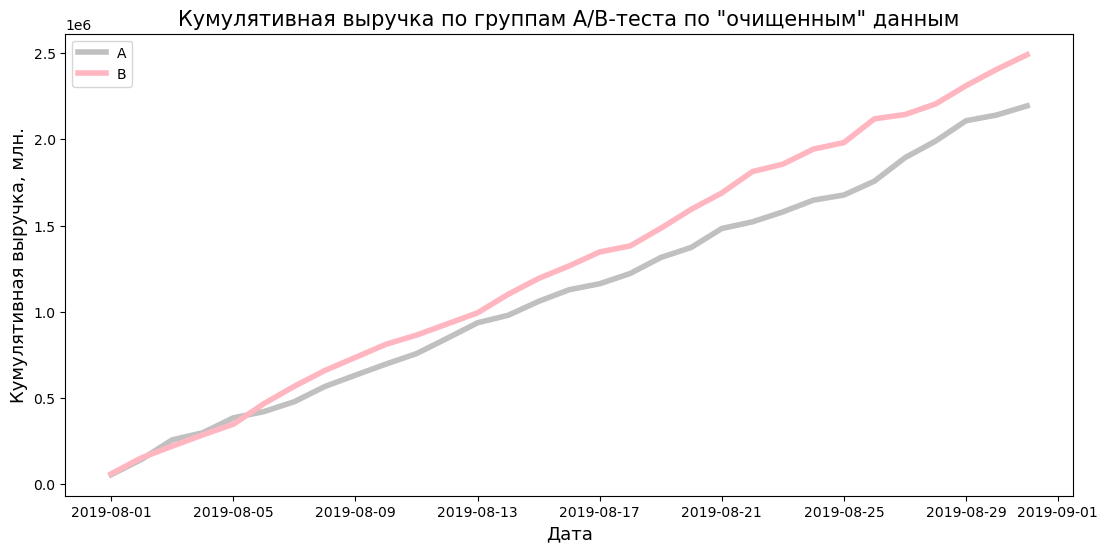

In [52]:
plt.figure(figsize=(13,6))
sns.lineplot(data=cum_rev_a_filtr, 
             x=cum_rev_a_filtr['date'], 
             y=cum_rev_a_filtr['revenue'], 
             color = 'silver', 
             linewidth = 4, 
             label='A')
sns.lineplot(data=cum_rev_b_filtr, 
             x=cum_rev_b_filtr['date'], 
             y=cum_rev_b_filtr['revenue'], 
             color = 'lightpink', 
             linewidth = 4, 
             label='B')
plt.title('Кумулятивная выручка по группам A/B-теста по "очищенным" данным',fontsize = 15)
plt.xlabel('Дата', fontsize = 13)
plt.ylabel('Кумулятивная выручка, млн.', fontsize = 13)
plt.legend()
plt.show()

Кумулятивная выручка на всем протяжении теста также растет, но уже более плавно по обеим группам. По очищенным данным кумулятивная выручка группы В превышает показатели группы А уже после первой недели теста.

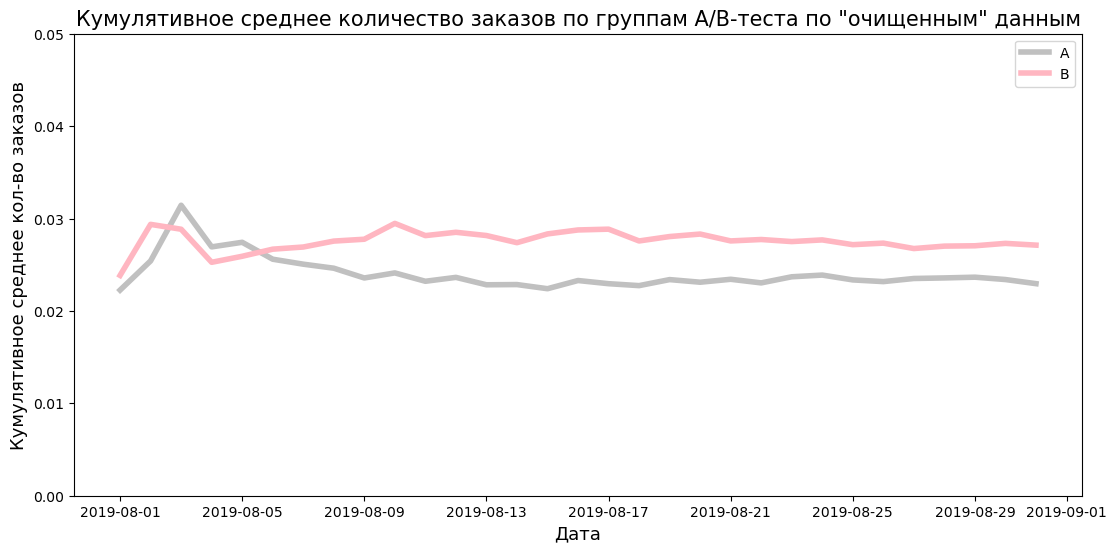

In [53]:
plt.figure(figsize=(13,6))
sns.lineplot(data=cum_rev_a, 
             x=cum_rev_a_filtr['date'], 
             y=cum_rev_a_filtr['conversion'], 
             color = 'silver', 
             linewidth = 4, 
             label='A')
sns.lineplot(data=cum_rev_b_filtr, 
             x=cum_rev_b_filtr['date'], 
             y=cum_rev_b_filtr['conversion'], 
             color = 'lightpink', 
             linewidth = 4, 
             label='B')
plt.title('Кумулятивное среднее количество заказов по группам A/B-теста по "очищенным" данным',fontsize = 15)
plt.xlabel('Дата', fontsize = 13)
plt.ylabel('Кумулятивное среднее кол-во заказов', fontsize = 13)
plt.legend()
plt.ylim(0, 0.05)
plt.show()

В данном случае, по сравнению с "сырыми" данными, картина практически не изменилась. В начале теста количество заказов на посетителя по группам менялись местами, но приблизительно на 7-й день теста графики перестроились - кривая показателя среднего количества заказов у группы В превышает линию группы А до конца теста. Приблизительно с 20-го августа графики стабилизировались. Ранее тест показал статистическую значимость различий в среднем количестве заказов между группами.

In [54]:
# найдем относительное различие среднего количества заказов 

conv_b_a_filtr = cum_data_filtered.pivot_table(index='date', values='conversion', columns='group', aggfunc='first').reset_index()
conv_b_a_filtr['ratio'] = conv_b_a_filtr['B'] / conv_b_a_filtr['A'] - 1
conv_b_a_filtr.head()

group,date,A,B,ratio
0,2019-08-01,0.022253,0.023843,0.071441
1,2019-08-02,0.025411,0.029366,0.155651
2,2019-08-03,0.031436,0.028841,-0.082564
3,2019-08-04,0.026932,0.025262,-0.061998
4,2019-08-05,0.027426,0.025915,-0.055113


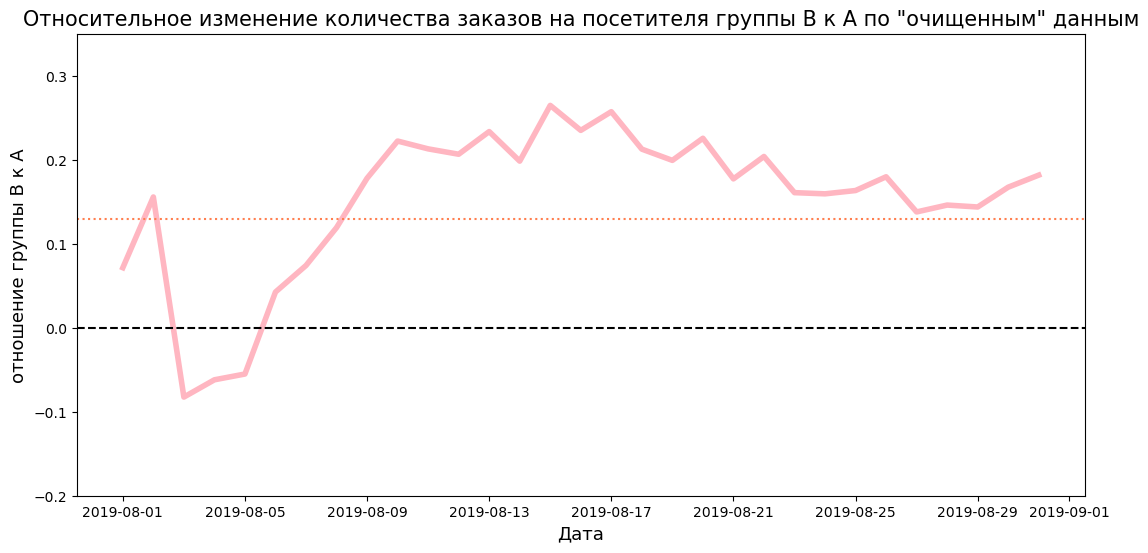

In [55]:
plt.figure(figsize=(13,6))
sns.lineplot(data=conv_b_a_filtr, 
             x=conv_b_a_filtr['date'], 
             y=conv_b_a_filtr['ratio'], 
             color = 'lightpink', 
             linewidth = 4)
plt.title('Относительное изменение количества заказов на посетителя группы B к A по "очищенным" данным',fontsize = 15)
plt.xlabel('Дата', fontsize = 13)
plt.ylabel('отношение группы В к А', fontsize = 13)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.13, color='coral', linestyle=':')
plt.ylim(-0.2, 0.35)
plt.show()

По "сырым" данным среднее количество заказов на посетителя группы А превышало группу В приблизительно первую неделю теста, по "очищенным" данным превышает только пару дней в начале теста, также примерно с 6-го августа заказы на посетителя группы В опередили данный показатель группы А и больше ниже нулевой отметки не опускалась. Приблизительно с 9-го августа метрика группы В не опускалась ниже 13% (по "сырым" данным не ниже 10%).

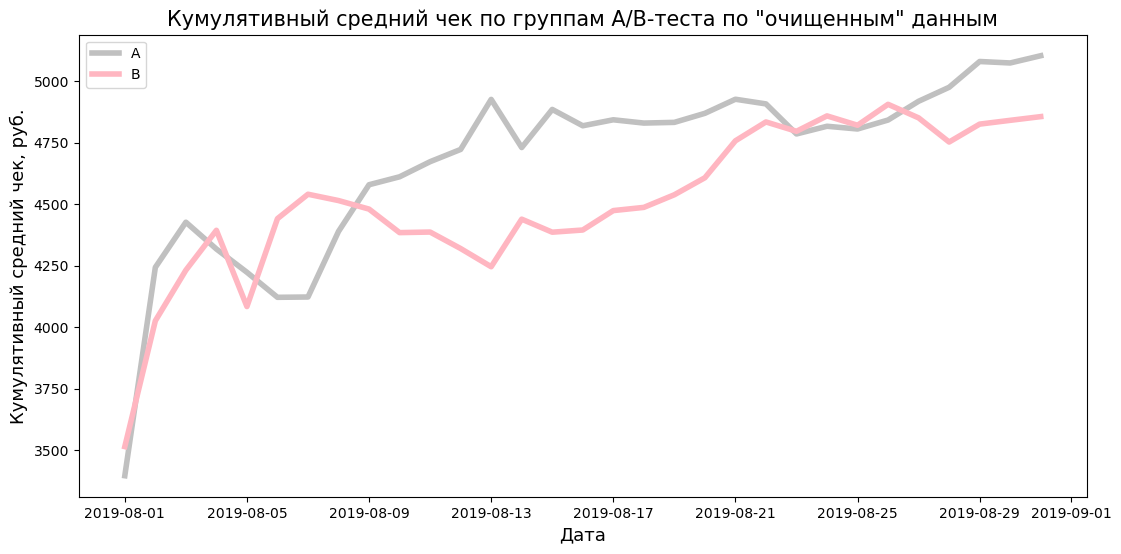

In [56]:
plt.figure(figsize=(13,6))
sns.lineplot(data=cum_rev_a_filtr, 
             x=cum_rev_a_filtr['date'], 
             y=cum_rev_a_filtr['avg_check'], 
             color = 'silver', 
             linewidth = 4, 
             label='A')
sns.lineplot(data=cum_rev_b_filtr, 
             x=cum_rev_b_filtr['date'], 
             y=cum_rev_b_filtr['avg_check'], 
             color = 'lightpink', 
             linewidth = 4, 
             label='B')
plt.title('Кумулятивный средний чек по группам A/B-теста по "очищенным" данным',fontsize = 15)
plt.xlabel('Дата', fontsize = 13)
plt.ylabel('Кумулятивный средний чек, руб.', fontsize = 13)
plt.legend()
plt.show()

Как и в случае с "сырыми" данными, графики кумулятивного среднего чека точно нестабильны. На протяжении всего теста мы видим перепады как в большую так и в меньшую сторону по обеим группам. Обе группы показывают тенденцию к росту.  Согласну тесту, статистически значимых различий между средними нет. Посмотрим на относительное изменения кумулятивного среднего чека группы B к группе A по "очищенным" данным.

In [57]:
# найдем относительное различие среднего чека 

avg_check_ratio_filtr = cum_data_filtered.pivot_table(index='date', values='avg_check', columns='group', aggfunc='first').reset_index()
avg_check_ratio_filtr['ratio'] = avg_check_ratio_filtr['B'] / avg_check_ratio_filtr['A'] - 1
avg_check_ratio_filtr.head()

group,date,A,B,ratio
0,2019-08-01,3396.937500,3515.176471,0.034808
1,2019-08-02,4243.029412,4026.105263,-0.051125
2,2019-08-03,4426.482759,4231.557692,-0.044036
3,2019-08-04,4317.565217,4393.553846,0.017600
4,2019-08-05,4223.021978,4083.988235,-0.032923


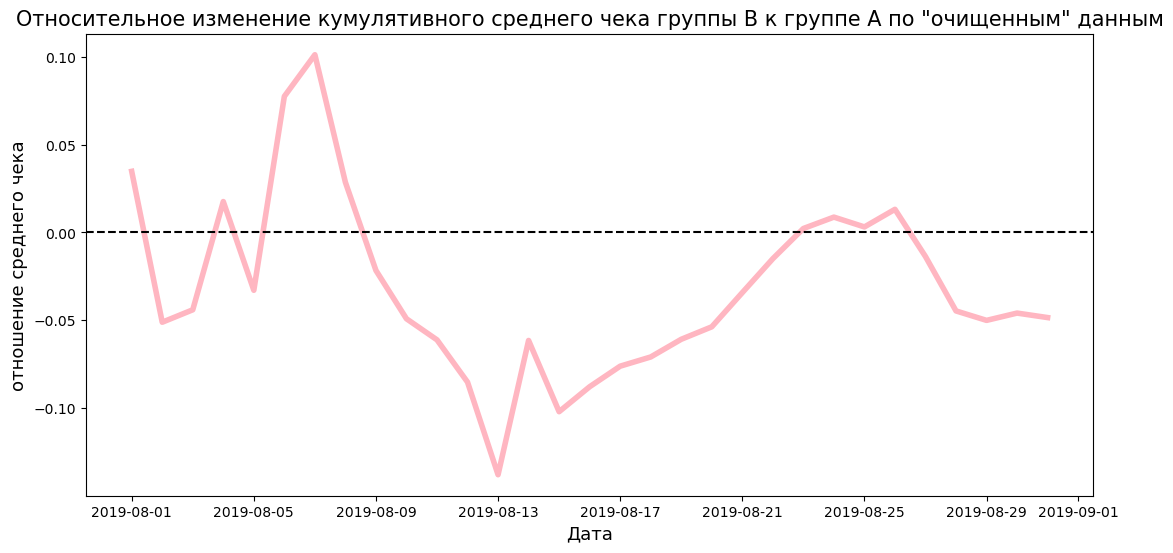

In [58]:
plt.figure(figsize=(13,6))
sns.lineplot(data=avg_check_ratio_filtr, 
             x=avg_check_ratio_filtr['date'], 
             y=avg_check_ratio_filtr['ratio'], 
             color = 'lightpink', 
             linewidth = 4)
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A по "очищенным" данным',fontsize = 15)
plt.xlabel('Дата', fontsize = 13)
plt.ylabel('отношение среднего чека', fontsize = 13)
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

График среднего чека изменчивый и показывает практически противоположную картину относительно графика по "сырым" данным. В данном случае бОльшее количество дней теста значение кумулятивного среднего чека группы А было больше чем у группы В. Как мы выяснили ранее относительная разница группы А к группе В составляет 4.85 %

### Решение по результатам теста

подытожим результаты А/В теста:  

- статистически значимых различий в среднем чеке заказа между группами как по «сырым», так и по "очищенным" данным - не выявлено. В обоих случаях p-value значительно превышает уровень стат.значимости. При этом по "сырым" данным относительная разница группы В к группе А составила 28.66 %, по "очищенным" же наоборот - разница группы А к группе В равна 4.85 %.
- среднее количество заказов на посетителя, наоборот, показывает статистически значимый результат, как по "сырым" данным, так и после удаления аномальных/выбивающихся значений. Относительная разница группы В к группе А по "сырым" данным составила ~ 16 %, по "очищенным" ~ 18%.
- графики среднего чека нестабильны на протяжении всего теста, по ним затруднительно делать однозначные выводы.
- графики количества заказов на посетителя подтверждают результаты теста, уже после первой недели кривая группы В превышает показатели группы А.
- графики кумулятивной выручки показывают, что у группы В показатель выше, как по "сырым", так и по "очищенным" данным.  

На основании вышеизложенного мы бы рекомендовали на данном этапе остановить тест и зафиксировать победу группы В, среднее количество заказов на посетителя группы В выше, как и показатель кумулятивной выручки.

## Выводы

- Выгрузили, изучили и предобработали полученные данные, где это было необходимо.
- Среди выдвинутых гипотез, с помощью фреймворков ICE и RICE, выявили наиболее приоритетные. Гипотезы с индексами 7 (Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок) и 0 (Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей) входят в тройку лидеров в обоих методах. Стоит учитывать что фреймворк RICE усиливает ICE параметром охвата - на сколько пользователей повлияет изменение, которое мы хотим внести.
- По результатам А/В теста было решено его завершить и признать победу за группой В, так как она показала статистически значимое различие среднего количества заказов на посетителя и более высокий показатель выручки
- Стоит обратить внимание на механизм проведения тестирования, т.к. при делении на группы пользователи были распределены неравномерно, а также 58 уникальных пользователей оказались и в группе А и в группе В.